Data processing method:

1) Import packages

2) Load in data

3) Standard cleaning, naming and indexing

4) View raw data as rough scatter plots

5) Remove negative time values

6) Segment heat flow sequences to remove irrelevant ones (main heating and cooling only)

7) Normalise mW to W/g

8) Isolate the heat flow section relevant to the crystallisation for the area peak

9) Final figure plots

10) Peak fitting 

11) Plot with fitted peak

12) Integration to determine crystallisation fraction, avrami exponent and rate constant

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [62]:
filepath = '/Users/thomasfish/Desktop/University_Work/II_Materials/P3_Polymer_Crystallisation/PEO50_cleaned.csv'

df1 = pd.read_csv(filepath, header=None, delimiter='\s+')
df1.columns = ['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%']

for col in ['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%']:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
df1 = df1.dropna(subset=['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%'])

t = df1['Time/m'].to_numpy()
T = df1['Temperature/C'].to_numpy()
HF = df1['Heat_Flow/mW'].to_numpy()
A = df1['Area/%'].to_numpy()

df1.head(-10)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_51156/4150770728.py:3: SyntaxWarning: invalid escape sequence '\s'
  df1 = pd.read_csv(filepath, header=None, delimiter='\s+')


,Time/m,Temperature/C,Heat_Flow/mW,Area/%
0,0.000500,28.64386,-2.428228,0.0
1,0.017167,28.50610,-2.289162,0.0
2,0.033833,28.43012,-2.260929,0.0
3,0.050500,28.42400,-2.324786,0.0
4,0.067167,28.48156,-2.304752,0.0
...,...,...,...,...
4679,77.900500,25.31211,-1.062556,0.0
4680,77.917180,25.29612,-1.022660,0.0
4681,77.933840,25.28906,-0.977872,0.0
4682,77.950500,25.27194,-0.944504,0.0


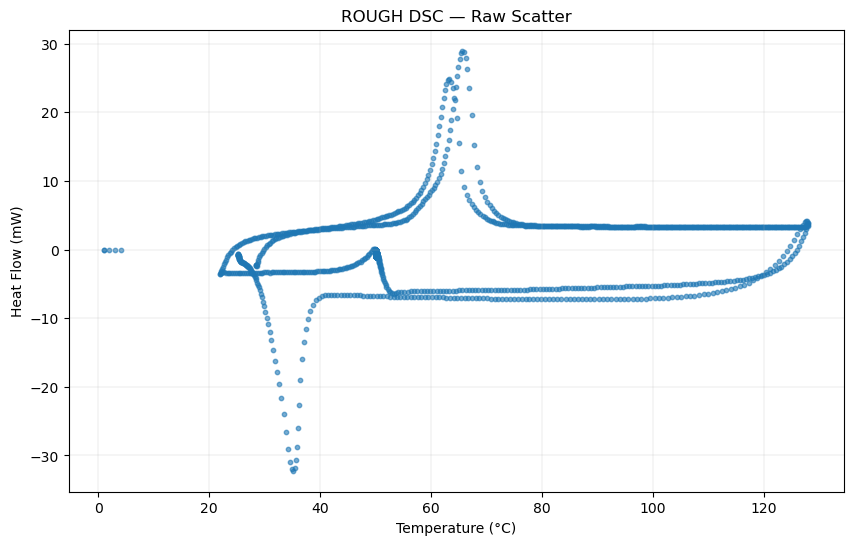

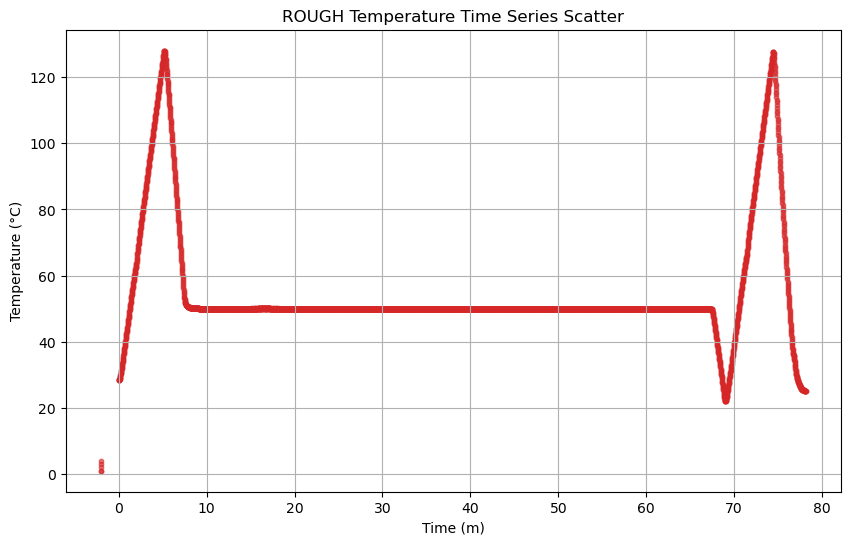

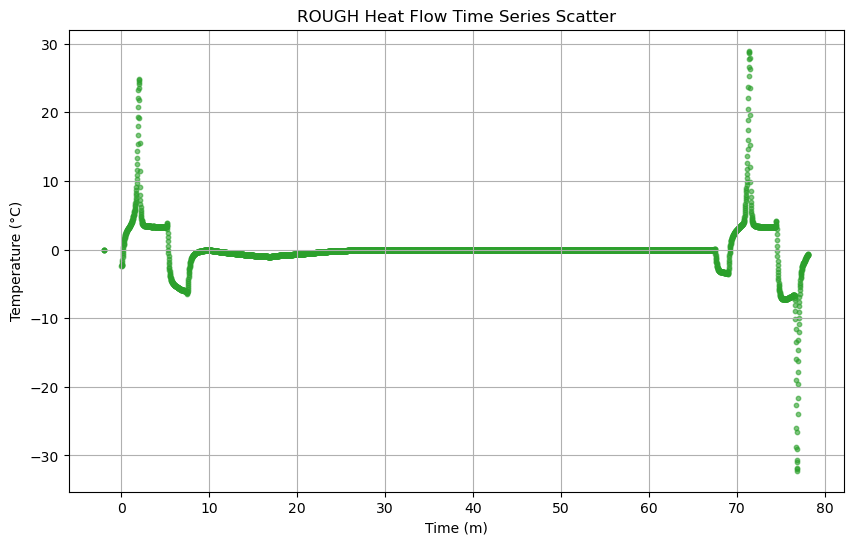

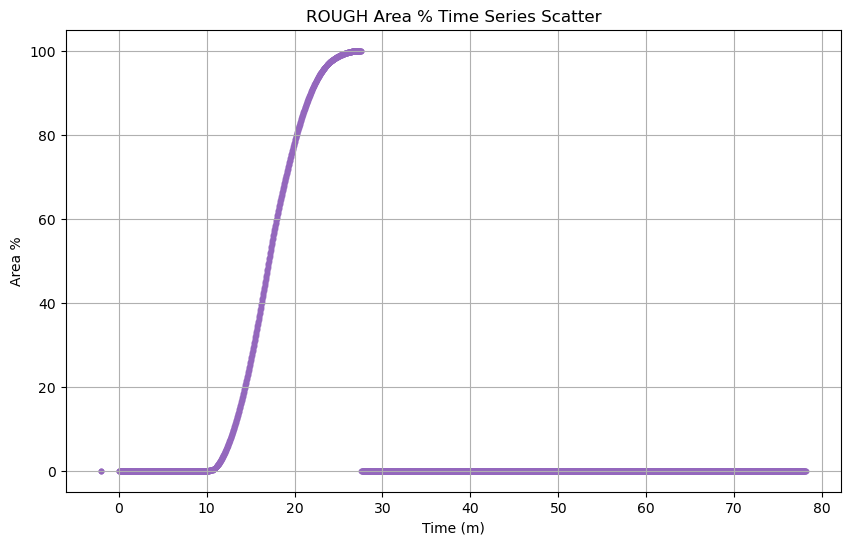

In [63]:
# Rough Scatter Plots to view raw data

plt.figure(figsize=(10, 6))
plt.scatter(T, HF, s=10, alpha=0.6, color='tab:blue')
plt.title('ROUGH DSC — Raw Scatter')
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (mW)')
plt.grid(True, lw=0.3, alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(t, T, s=10, alpha=0.6, color='tab:red')
plt.title('ROUGH Temperature Time Series Scatter')
plt.xlabel('Time (m)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(t, HF, s=10, alpha=0.6, color='tab:green')
plt.title('ROUGH Heat Flow Time Series Scatter')
plt.xlabel('Time (m)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(t, A, s=10, alpha=0.6, color='tab:purple')
plt.title('ROUGH Area % Time Series Scatter')
plt.xlabel('Time (m)')
plt.ylabel('Area %')
plt.grid(True)
plt.show()

In [64]:
# Additional Processing based on plots

# Remove any rows where time is negative
df1 = df1[df1['Time/m'] >= 0].copy()
df1.reset_index(drop=True, inplace=True)

# --- find heating-only segments ---------------------------------------------
TEMP_EPS = 0.05  # °C, ignore tiny jitters around turning points

dT = np.diff(T, prepend=T[0])
trend = np.sign(dT)
trend[np.abs(dT) < TEMP_EPS] = 0

# forward-fill zeros so plateaus inherit previous direction
for i in range(1, len(trend)):
    if trend[i] == 0:
        trend[i] = trend[i-1]
if trend[0] == 0:
    nz = np.flatnonzero(trend)
    trend[0] = trend[nz[0]] if nz.size else 0

# segment boundaries where direction changes
cuts = np.where(np.diff(trend) != 0)[0] + 1
starts = np.r_[0, cuts]
ends   = np.r_[cuts, len(T)]

heating_segments = []
for s, e in zip(starts, ends):
    if e - s < 10:              # drop very short fragments
        continue
    if T[e-1] <= T[s] + 1e-9:   # keep only heating
        continue
    heating_segments.append({
        "start": s,
        "end": e,
        "span": T[e-1] - T[s],  # temperature range of the segment
        "npts": e - s
    })

if not heating_segments:
    raise RuntimeError("No heating segment found. Consider increasing TEMP_EPS.")

# keep the single largest heating ramp (by temperature span; use 'npts' for duration)
largest = max(heating_segments, key=lambda seg: seg['span'])  # or key=lambda seg: seg['npts']
sl = slice(largest['start'], largest['end'])

T_h  = T[sl]
HF_h = HF[sl]

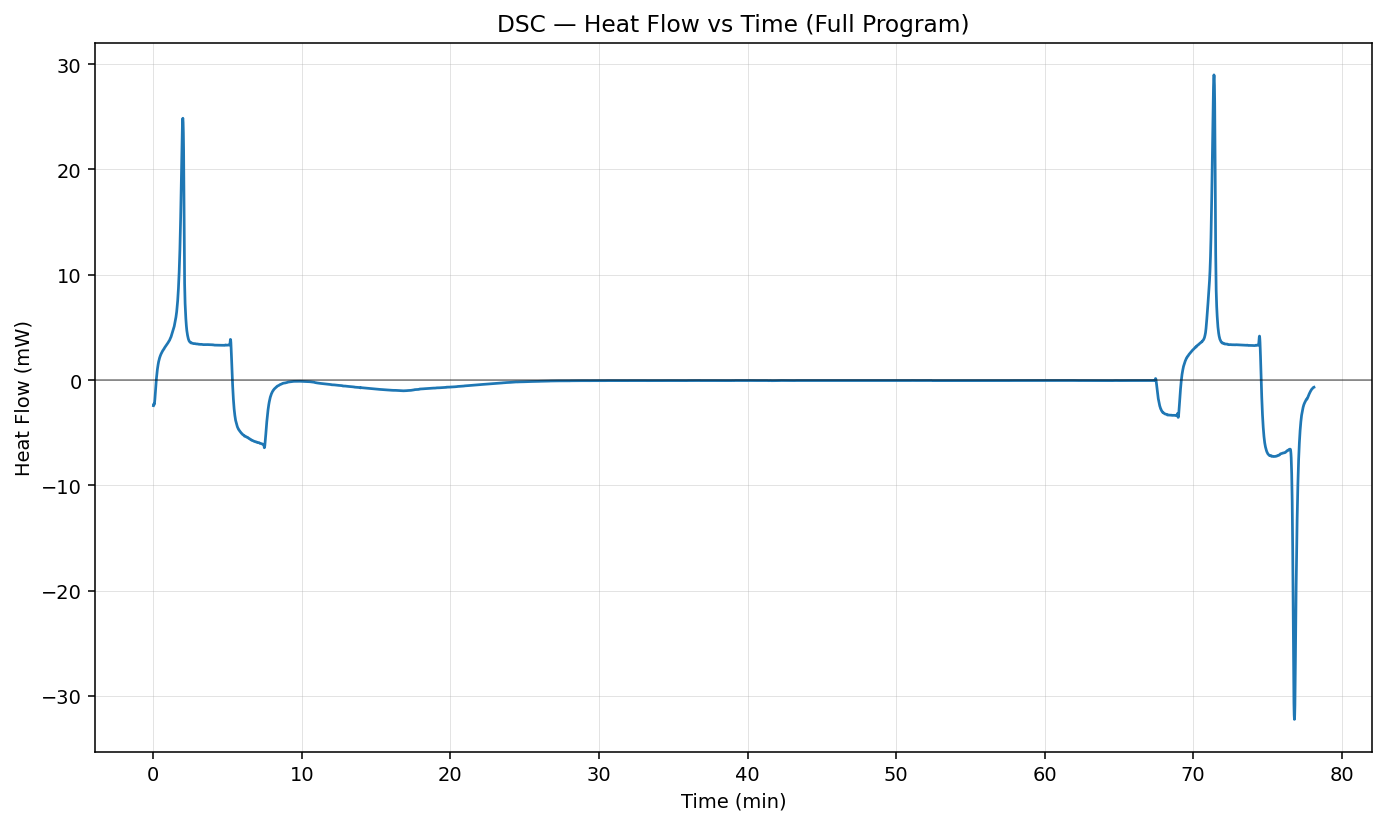

In [65]:
# Plot 2 - Heat flow time series (full data)

plt.figure(figsize=(10, 6), dpi=140)
plt.plot(df1['Time/m'], df1['Heat_Flow/mW'], color='tab:blue', lw=1.4)
plt.axhline(0, color='k', lw=0.8, alpha=0.5)
plt.title('DSC — Heat Flow vs Time (Full Program)')
plt.xlabel('Time (min)')
plt.ylabel('Heat Flow (mW)')
plt.grid(True, lw=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

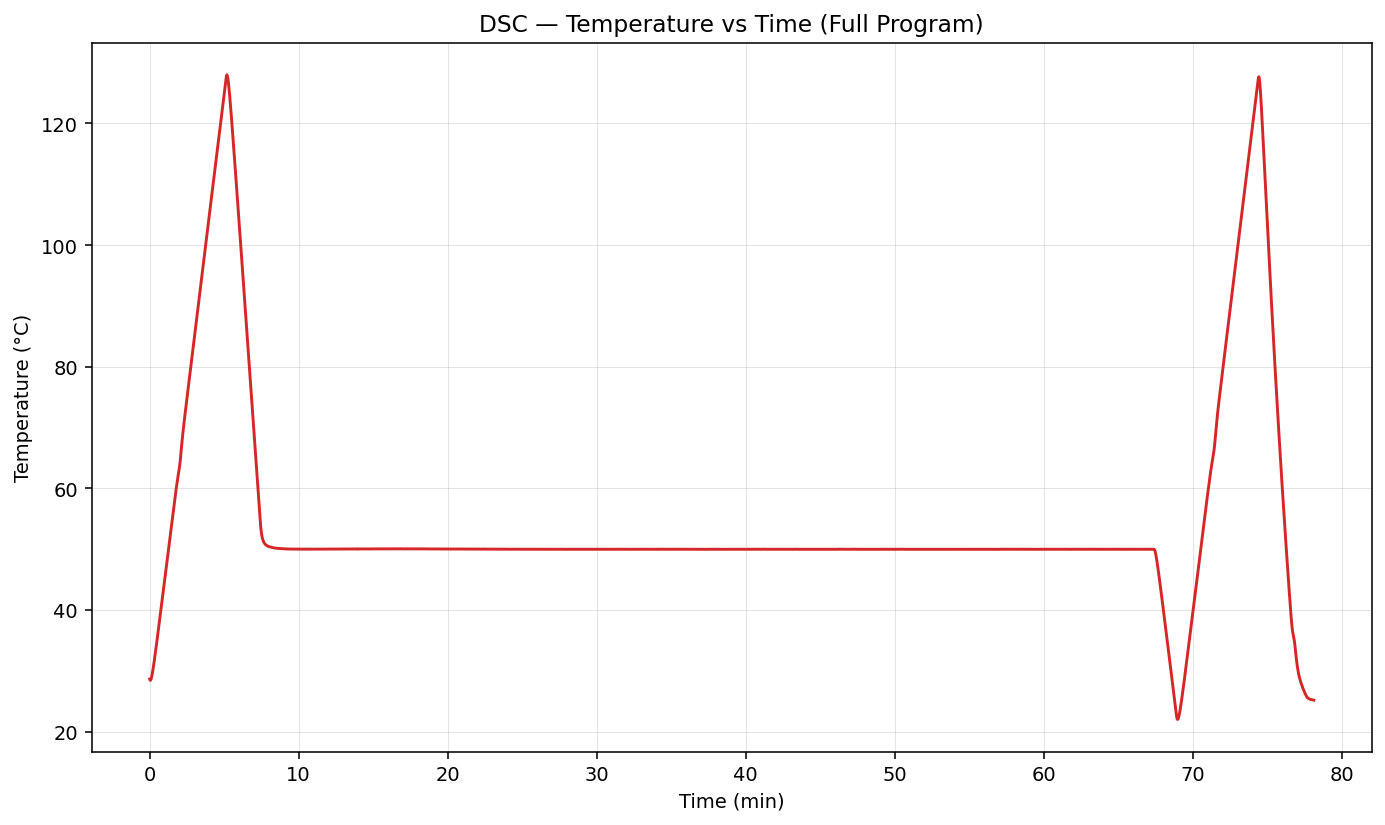

In [66]:
# Plot 3 - Temperature time series (full data)

plt.figure(figsize=(10, 6), dpi=140)
plt.plot(df1['Time/m'], df1['Temperature/C'], color='tab:red', lw=1.5)

plt.title('DSC — Temperature vs Time (Full Program)')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (°C)')
plt.grid(True, lw=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

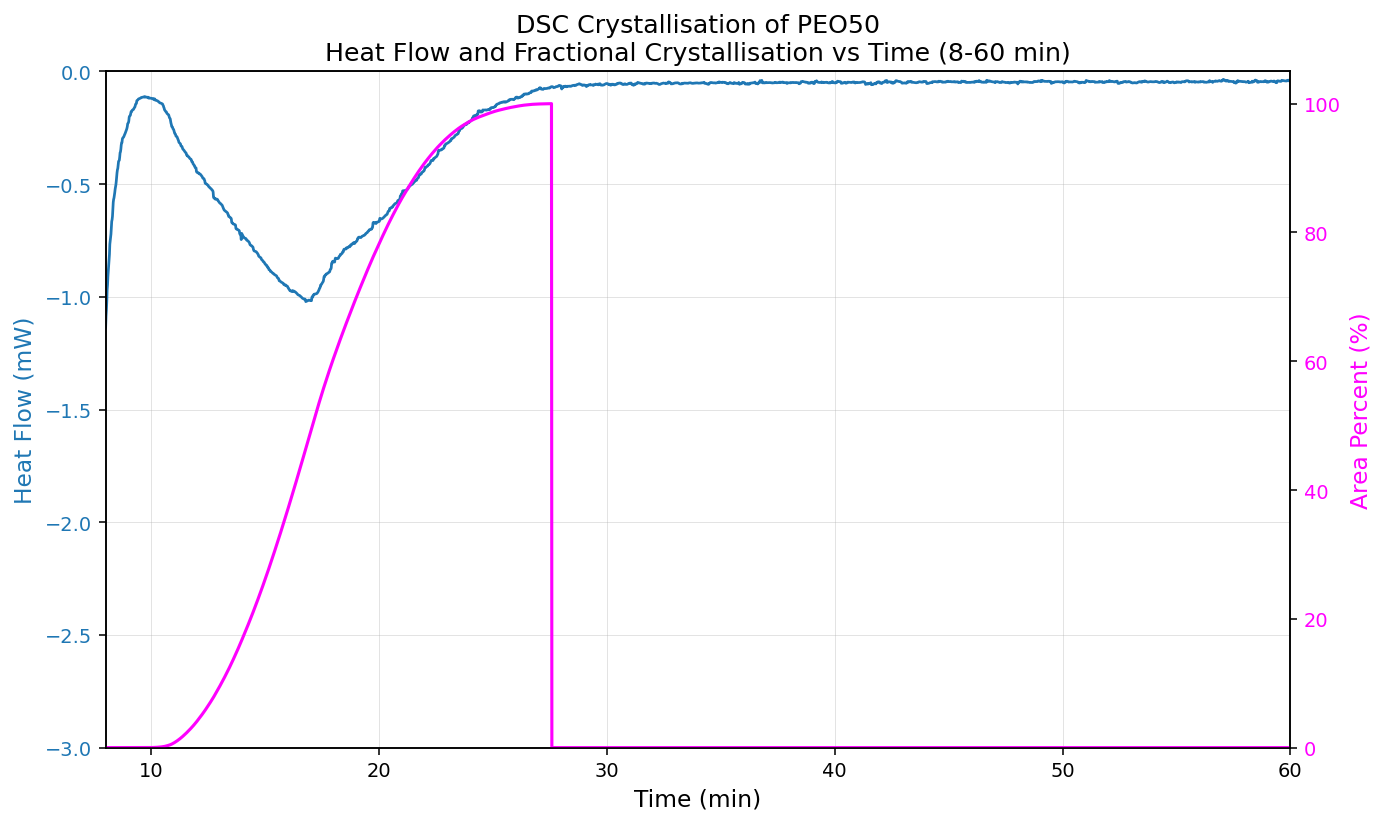

In [67]:
# --- Define the time window for this plot only ---
mask = (df1['Time/m'] >= 8) & (df1['Time/m'] <= 60)
df_window = df1.loc[mask].copy()

# --- Create dual-axis plot ---
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=140)

# Left y-axis → Heat Flow
ax1.plot(df_window['Time/m'], df_window['Heat_Flow/mW'],
         color='tab:blue', lw=1.4, label='Heat Flow (mW)')
ax1.set_xlabel('Time (min)', fontsize=12)
ax1.set_ylabel('Heat Flow (mW)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='k', lw=0.8, alpha=0.5)
ax1.grid(True, lw=0.3, alpha=0.6)

# Right y-axis → Area %
ax2 = ax1.twinx()
ax2.plot(df_window['Time/m'], df_window['Area/%'],
         color='magenta', lw=1.6, label='Area Percent (%)')
ax2.set_ylabel('Area Percent (%)', color='magenta', fontsize=12)
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.set_ylim(0, 105)

# --- Title and limits ---
ax1.set_xlim(8, 60)
ax1.set_ylim(-3,0)
plt.title('DSC Crystallisation of PEO50\nHeat Flow and Fractional Crystallisation vs Time (8-60 min)',
          fontsize=13)
fig.tight_layout()
plt.show()

Integrated area (ΔH): 140.83 J/g


/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_51156/2517634333.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_mJ = np.trapz(HF_corr[mask], x=t_h)       # mW·s = mJ


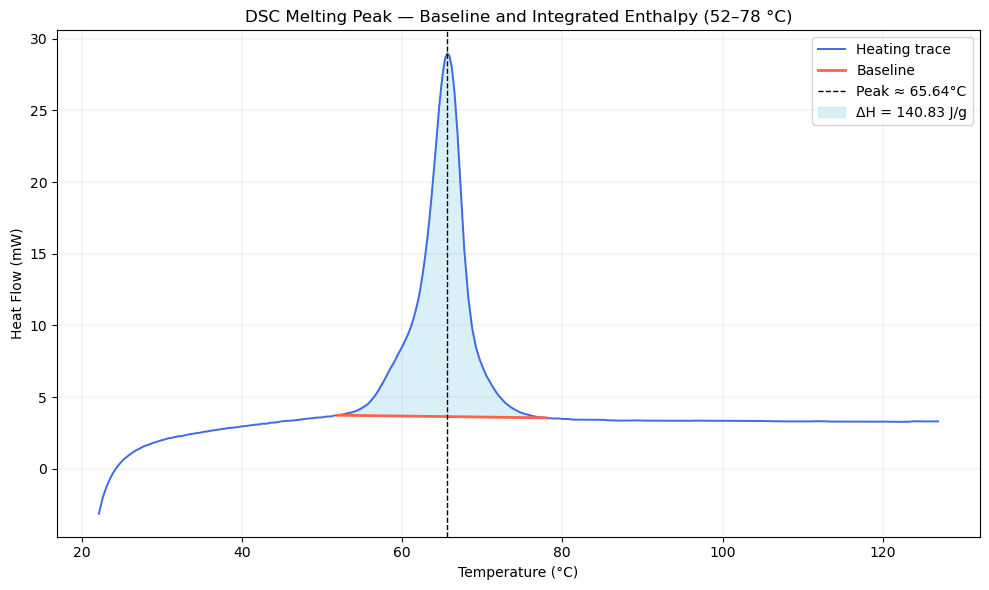

In [68]:
# --- Manual baseline and integration of melting peak (52–78 °C) -------------

# Define baseline by eye
T_left, T_right = 52.0, 78.0
HF_left = np.mean(HF_h[(T_h > 51) & (T_h < 53)])  # average small region near 52 °C
HF_right = np.mean(HF_h[(T_h > 77) & (T_h < 79)]) # average small region near 78 °C

# Linear baseline between anchor points
a = (HF_right - HF_left) / (T_right - T_left)
b = HF_left - a * T_left
def baseline(Tvals): 
    return a * Tvals + b

# Subtract baseline
HF_corr = HF_h - baseline(T_h)

# Locate peak maximum
i_peak = np.argmax(HF_corr)
T_peak = T_h[i_peak]
HF_peak = HF_h[i_peak]

# Integrate area under peak (baseline-corrected)
mask = (T_h >= T_left) & (T_h <= T_right)
t_h = df1['Time/m'].to_numpy()[sl][mask] * 60  # convert min → s
area_mJ = np.trapz(HF_corr[mask], x=t_h)       # mW·s = mJ
mass_mg = 3.5010                               # sample mass (mg)
area_Jg = area_mJ / (mass_mg / 1000) / 1000    # convert to J/g

print(f"Integrated area (ΔH): {area_Jg:.2f} J/g")

# --- Plot the heating trace, baseline, and integrated area ------------------
plt.figure(figsize=(10,6))
plt.plot(T_h, HF_h, color='royalblue', lw=1.4, label='Heating trace')
plt.plot([T_left, T_right], [HF_left, HF_right], color='tomato', lw=2, label='Baseline')
plt.axvline(T_peak, color='k', lw=1, linestyle='--', label=f'Peak ≈ {T_peak:.2f}°C')
plt.fill_between(T_h[mask], HF_h[mask], baseline(T_h[mask]),
                 color='skyblue', alpha=0.3, label=f'ΔH = {area_Jg:.2f} J/g')

plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Flow (mW)')
plt.title('DSC Melting Peak — Baseline and Integrated Enthalpy (52–78 °C)')
plt.legend()
plt.grid(True, lw=0.3, alpha=0.6)
plt.tight_layout()
plt.show()
